In [6]:
import os
import numpy as np
import matplotlib
import cv2 as cv
import os
import tensorflow as tf
import io
import seaborn as sns
import glob
from google.cloud import storage
from matplotlib import pyplot as plt
from xml.dom import minidom
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from numpy import savez_compressed
from numpy import load
from sklearn.model_selection import train_test_split
from tensorflow.python.lib.io import file_io

# Config

Configuration of important paths and settings / functions to enable up- and download from Google Cloud Storage.

In [3]:
imgs_path = 'data/raw/Images'
anntn_path = 'data/raw/Annotation'
prcssd_path = 'data/processed'
split_path = 'data/split'

In [3]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'ServiceKey_GoogleCloud.json'
storage_client = storage.Client()
data_bucket = storage_client.get_bucket('exsem-dog-classification')

In [13]:
def upload_to_bucket(file_path, bucket_name):
    try:
        bucket = storage_client.get_bucket(bucket_name)
        blob = bucket.blob(file_path)
        blob.upload_from_filename(file_path)
        return 'succesfull upload'
    except Exception as e:
        print(e)
        return 'upload failed'

In [14]:
def download_file_from_bucket(file_path, bucket_name):
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(file_path)
    with open(file_path, 'wb') as f:
        storage_client.download_blob_to_file(blob, f)
    print('Saved')

# Data Acquisition

In [44]:
'''
for subfolder in os.listdir(anntn_path):
    if subfolder == '.DS_Store' or subfolder == '.gitignore':
        continue
    for item in os.listdir(anntn_path + '/' + subfolder):
        blob = data_bucket.blob(anntn_path + '/' + subfolder + '/' + item)
        blob.upload_from_filename(anntn_path + '/' + subfolder + '/' + item)
'''

In [7]:
'''
anntn_paths = []
for subfolder in os.listdir(anntn_path):
    if subfolder == '.DS_Store' or subfolder == '.gitignore':
        continue
    for item in os.listdir(anntn_path + '/' + subfolder):
        anntn_paths.append(anntn_path + '/' + subfolder + '/' + item)

np.save(file='data/raw/annotations_paths.npy', arr = anntn_paths)
'''

In [65]:
anntn_paths = np.load(file='data/raw/annotation_paths.npy')

for a in anntn_paths:
    subdir_name = a[20:a.rfind('/')]
    
    if not os.path.exists(anntn_path + '/' + subdir_name):
        os.mkdir(anntn_path + '/' + subdir_name)
    
    blob = data_bucket.blob(a)

    with open(a, 'wb') as f:
        storage_client.download_blob_to_file(blob, f)

**Download** from Google Cloud Storage:

In [ ]:
for subfolder in os.listdir(imgs_path):
    if subfolder == '.DS_Store' or subfolder == '.gitignore':
        continue
    for item in os.listdir(imgs_path + '/' + subfolder):
        blob = data_bucket.blob(imgs_path + '/' + subfolder + '/' + item)
        blob.upload_from_filename(imgs_path + '/' + subfolder + '/' + item)

In [8]:
'''
img_paths = []
for subfolder in os.listdir(imgs_path):
    if subfolder == '.DS_Store' or subfolder == '.gitignore':
        continue
    for item in os.listdir(imgs_path + '/' + subfolder):
        img_paths.append(imgs_path + '/' + subfolder + '/' + item)

np.save(file='data/raw/images_paths.npy', arr = img_paths)
'''

In [ ]:
img_paths = np.load(file='data/raw/images_paths.npy')

for i in img_paths:
    subdir_name = i[20:i.rfind('/')]
    
    if not os.path.exists(img_paths + '/' + subdir_name):
        os.mkdir(img_paths + '/' + subdir_name)
    
    blob = data_bucket.blob(i)

    with open(a, 'wb') as f:
        storage_client.download_blob_to_file(blob, f)

# Data Exploration

## How does the dataset look like?

In [20]:
breeds_path = os.listdir(imgs_path)
if '.DS_Store' in breeds_path:
    breeds_path.remove('.DS_Store')
if '.gitignore' in breeds_path:
    breeds_path.remove('.gitignore')

print('There are ' + str(len(breeds_path)) + ' different dog breeds in this dataset.')

There are 120 different dog breeds in this dataset.


In [35]:
dogs_path = []

for b in breeds_path:
    dog_path = os.listdir(imgs_path + '/' + b)
    new_dog_path = [imgs_path + '/' + b + '/' + d for d in dog_path]
    
    dogs_path.append(new_dog_path)


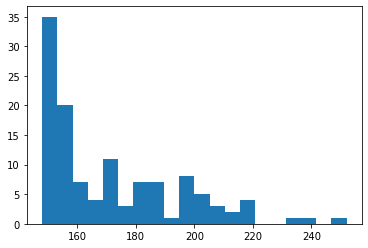

Minimum images per breed: 148
Maximum images per breed: 252
Total images across dataset: 20580


In [22]:
img_per_breed = []

for b in range(len(breeds_path)):
    img_per_breed.append(len(dogs_path[b]))

plt.hist(img_per_breed, bins = 20)
plt.show()

print('Minimum images per breed: ' + str(min(img_per_breed)))
print('Maximum images per breed: ' + str(max(img_per_breed)))
print('Total images across dataset: ' + str(sum(img_per_breed)))

Lets take a look into some images (one per breed):

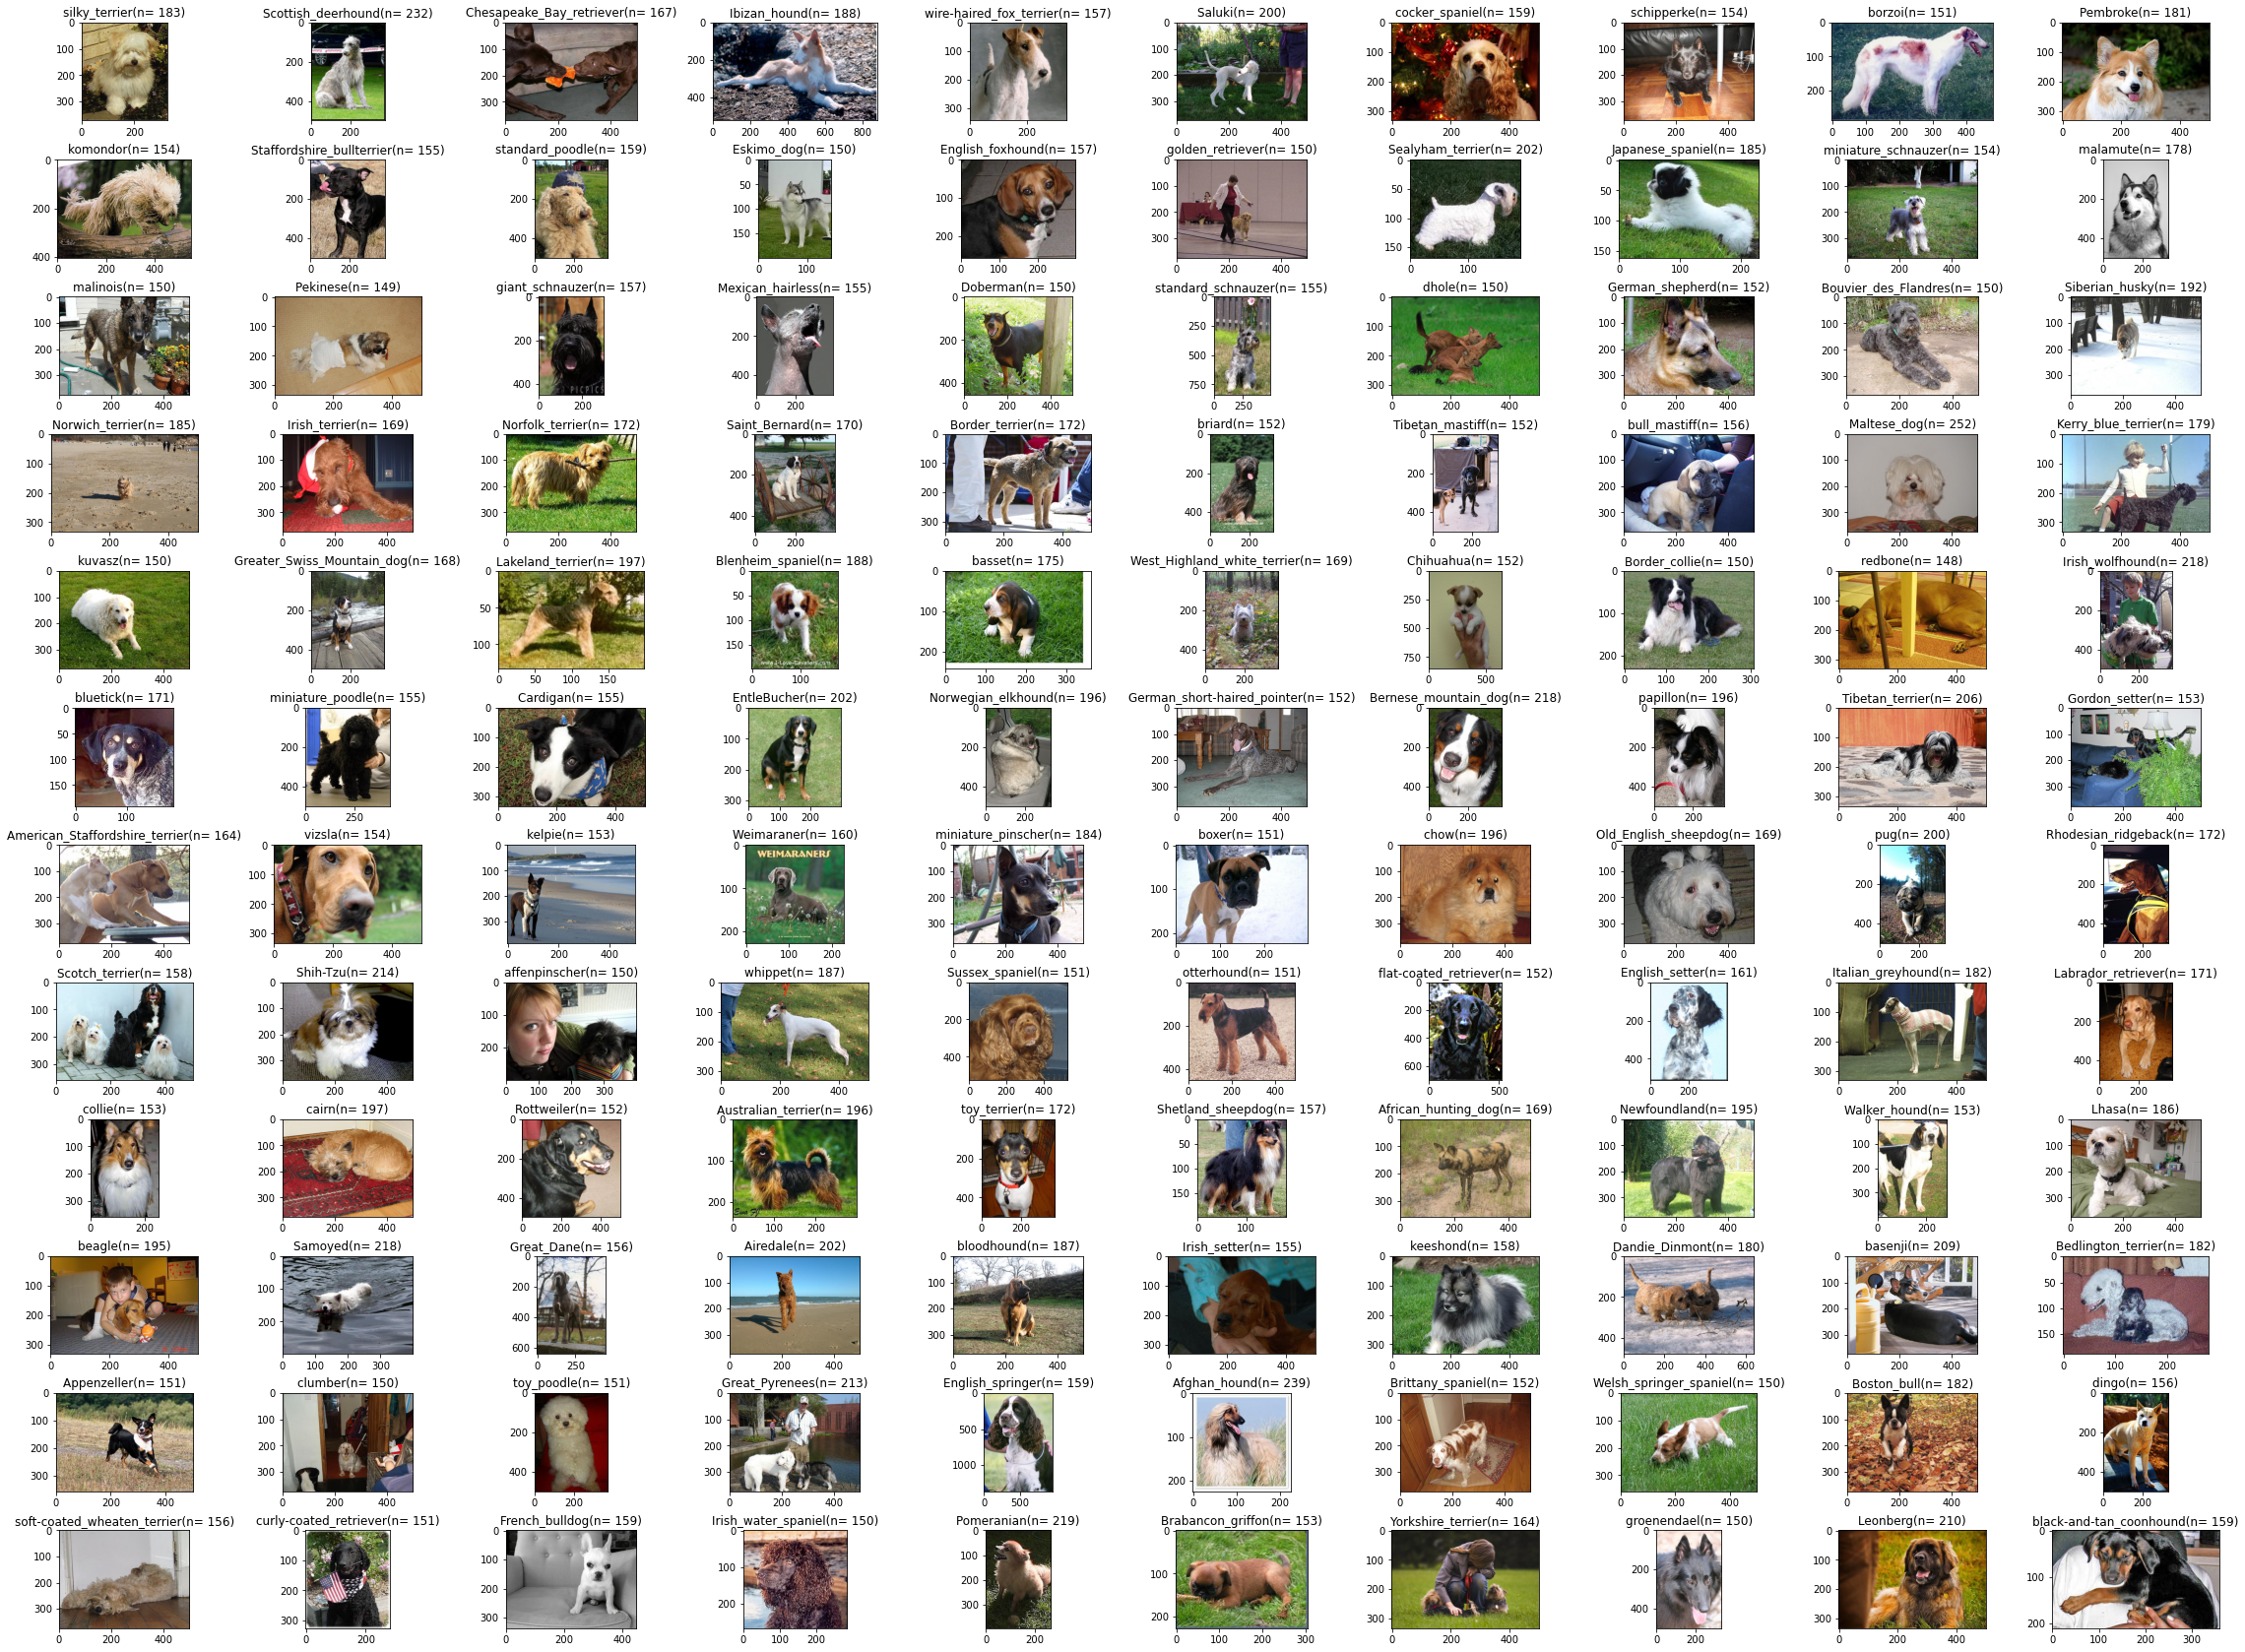

In [24]:
plt.figure(figsize=(40,30))

for b in range(len(dogs_path)):
    d = np.random.randint(0, len(dogs_path[b]))
    
    plt.subplot(12,10,b+1)

    dog = cv.imread(dogs_path[b][d])
    dog = cv.cvtColor(dog, cv.COLOR_BGR2RGB)

    plt.imshow(dog)
    plt.subplots_adjust(hspace = .4)
    
    i1 = dogs_path[b][d].index('-')
    i2 = dogs_path[b][d].find('/',dogs_path[b][d].index('-'))
    breed_name = dogs_path[b][d][i1+1:i2]
    plt.title(breed_name + '(n= ' + str(len(dogs_path[b])) + ')')


**Result:**

* Images are overall pretty diverse.
* Some dogs look straight into the camera, others look sideways or away from the camera.
* On some images, there are multiple dogs of the same breed.
* The Dogs are not always centred, some take only a quarter of the image.
* Besides the dogs, there are other elements (mostly humans) on the pictures aswell.
* Some dogs wear coats, funny little hats or have toys in their mouths.
* Pixelsize and -ratio seems to be very diverse across the dataset.
* None of the breeds is underrepresented or overrepresented. The dataset is pretty balanced overall.

## How is the images width's and height's?

In [8]:
img_sizes = []

for breed in dogs_path:
    for i in breed:
        image = Image.open(i)
        w, h = image.size
        img_sizes.append([w,h])

'''
    xmldoc = minidom.parse('Annotation/'+ f + '/' + a)
    w = int(xmldoc.getElementsByTagName('width')[0].firstChild.nodeValue)
    h = int(xmldoc.getElementsByTagName('height')[0].firstChild.nodeValue)
    size.append([w,h])

'''

img_sizes = np.array(img_sizes)

In [9]:
print('Minimum width pixels: ' + str(min(img_sizes[:,0])))
print('Minimum height pixels: ' + str(min(img_sizes[:,1])))
print('Maximum width pixels: ' + str(max(img_sizes[:,0])))
print('Maximum height pixels: ' + str(max(img_sizes[:,1])))

Minimum width pixels: 97
Minimum height pixels: 100
Maximum width pixels: 3264
Maximum height pixels: 2562


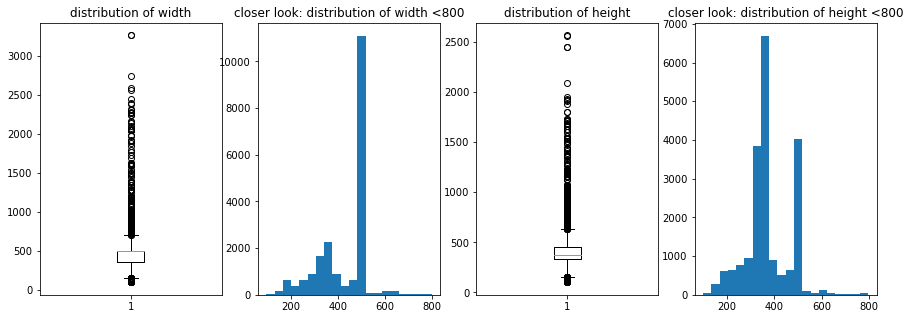

In [10]:
plt.figure(figsize=(15,5)) 

plt.subplot(1, 4, 1)
plt.boxplot(img_sizes[:,0])
plt.title('distribution of width')

plt.subplot(1, 4, 2)
plt.hist(img_sizes[img_sizes[:,0]<800][:,0], bins = 20)
plt.title('closer look: distribution of width <800')

plt.subplot(1, 4, 3)
plt.boxplot(img_sizes[:,1])
plt.title('distribution of height')

plt.subplot(1, 4, 4)
plt.hist(img_sizes[img_sizes[:,1]<800][:,1], bins = 20)
plt.title('closer look: distribution of height <800')


plt.show()

**Result:**

Most of the images are within a range of 200 to 500 pixels. Overall, images in the dataset are wider than taller. We should take a look into the ratio.

Before that, lets check the tiny images, since the README of Dataset says every image is atleast 200x200 pixels big. However, the minimum we found out is ~100 pixels. 

**How many are below the promised 200pixels?**

In [11]:
small = len(img_sizes[np.logical_or (img_sizes[:,0] < 200, img_sizes[:,1] < 200)])
length = len(img_sizes)
share = small / len(img_sizes) * 100
txt = '{0} out of {1} ({2:.2f} %) images are smaller than the expected 200x200 pixels.'
print(txt.format(small, length, share))

973 out of 20580 (4.73 %) images are smaller than the expected 200x200 pixels.


**Result:**

These images will probably need to be upscaled.

## How is the images ratio?

In [12]:
img_ratio = img_sizes[:,0] / img_sizes[:,1] 

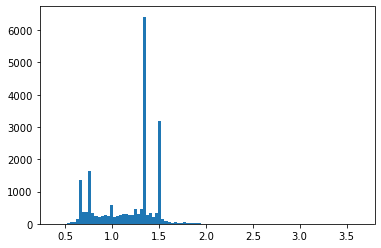

In [13]:
plt.hist(img_ratio, bins = 100)
plt.show()

In [14]:
unique, counts = np.unique(img_ratio, return_counts=True)
img_ratio_count = dict(zip(unique, counts))

In [15]:
dict(sorted(img_ratio_count.items(), key=lambda item: item[1], reverse = True)[:11])

{1.3333333333333333: 5966,
 1.5015015015015014: 2098,
 0.75: 1336,
 0.666: 706,
 1.0: 360,
 1.4970059880239521: 358,
 1.5060240963855422: 300,
 1.25: 183,
 0.668: 139,
 1.4005602240896358: 117,
 1.3368983957219251: 112}

**Result:**
There is alot of variety in the amount of pixels and the ratio. **Problem:** we need a fixed size for every image as model input.

Therefore, we need to resize most of the images to a fixed size. This leads to the question: **Which size is the best?**

Unfortunately, there is no clear answer to that. Lower resolution -> less information which may cause loss in accuracy, Higher resolution -> More computation power neeeded.
Most of the pretrained Models (e.g. ResNet, VGG16, Inceptionv3) use a 1:1 ratio with a pixel size higher than 200x200 (e.g. VGG16 and ResNet expect 224x224). 

So for the start: We will stick to their choice and go with 224x224. 


# Data Preparation

Based upon Data Exploration Results: 
* We need to create Y-Labels, since they are not given as a matrix.
* Images are pretty diverse. For now, we dont need further data augmentation other than fixing ratio and height.
* Lastly, we need to make the train-, test-, vali split.

## Create y-Label

The function used to create y, which is one hot encoded, does this based on the sorted directory. 
Thus, we can derive the y-labels by the sorted directory names.

In [6]:
breeds_path = os.listdir(imgs_path)
if '.DS_Store' in breeds_path:
    breeds_path.remove('.DS_Store')
if '.gitignore' in breeds_path:
    breeds_path.remove('.gitignore')

sorted_breed_paths = np.sort(breeds_path)

y_labels=[]
for y in range(len(sorted_breed_paths)):
    y_labels.append(sorted_breed_paths[y][sorted_breed_paths[y].index('-')+1:].title())


In [7]:
def get_ylabel(y_oh):
    return y_labels[np.argmax(y_oh)]

**Save** to directory:

In [8]:
np.save(file=prcssd_path + '/y_labels.npy', arr = y_labels)

**Upload** to Google Cloud Storage from local directory:

In [15]:
upload_to_bucket(prcssd_path + '/y_labels.npy', data_bucket)

True

**Download** from Google Cloud Storage to local directory: 

In [16]:
download_file_from_bucket(prcssd_path + '/y_labels.npy' , data_bucket)

Saved


**Load** from directory:

In [11]:
y_labels = np.load(prcssd_path + '/y_labels.npy')

## Picture Augmentation & Resizing

In [88]:
gen = ImageDataGenerator(
    rescale=1./255
    #featurewise_center=False, 
    #samplewise_center=False,
    #featurewise_std_normalization=False, 
    #samplewise_std_normalization=False,
    #zca_whitening=False, 
    #zca_epsilon=1e-06, 
    #rotation_range=0, 
    #width_shift_range=0.0,
    #height_shift_range=0.0, 
    #brightness_range=None, 
    #shear_range=0.0, 
    #zoom_range=0.0,
    #channel_shift_range=0.0, 
    #fill_mode='nearest', 
    #cval=0.0,
    #horizontal_flip=False, 
    #vertical_flip=False, 
    #preprocessing_function=None, 
    #data_format=None, 
    #validation_split=0.0, 
    #dtype=None,
)

In [11]:
aug = gen.flow_from_directory(
    directory = imgs_path, 
    target_size=(224, 224), 
    color_mode='rgb', 
    #class_mode='categorical', 
    batch_size=1, 
    shuffle=False, 
    seed=1,
    #save_to_dir=prcssd_path, 
    #save_prefix=, 
    #save_format='jpg',
    #follow_links=False, 
    #subset=None,
    interpolation='nearest'
)

Found 20580 images belonging to 120 classes.


In [8]:
X=[]
y=[]
aug.reset()
for i in range(aug.__len__()):
   single_x, single_y = aug.next()
   X.append(single_x)
   y.append(single_y)

X=np.array(X)
y=np.array(y)

X = X.reshape(aug.__len__(), 224, 224, 3)
y = y.reshape(aug.__len__(),120)


In [59]:
y=np.concatenate([aug.next()[1] for i in range(aug.__len__())])

In [ ]:
print('Shape of X:' + str(X.shape))
print('Shape of y:' + str(y.shape))

**Save** to directory:

In [60]:
savez_compressed(prcssd_path + '/X.npz', X)
np.save(file=prcssd_path + '/y.npy', arr = y)

**Upload** to Google Cloud Storage from local directory:

In [12]:
upload_to_bucket(prcssd_path + '/X.npz', data_bucket)
upload_to_bucket(prcssd_path + '/y.npy', data_bucket)

True

**Download** from Google Cloud Storage to local directory: 

In [77]:
download_file_from_bucket(prcssd_path + '/X.npz' , data_bucket)
download_file_from_bucket(prcssd_path + '/y.npy' , data_bucket)

Saved
Saved


**Load** from directory:

In [5]:
dict_data = load(prcssd_path + '/X.npz')
X = dict_data['arr_0']
y = np.load(prcssd_path + '/y.npy')

In [6]:
print('Shape of X:' + str(X.shape))
print('Shape of y:' + str(y.shape))

Shape of X:(20580, 224, 224, 3)
Shape of y:(20580, 120)


Check some individual images to see the augmented dataset.

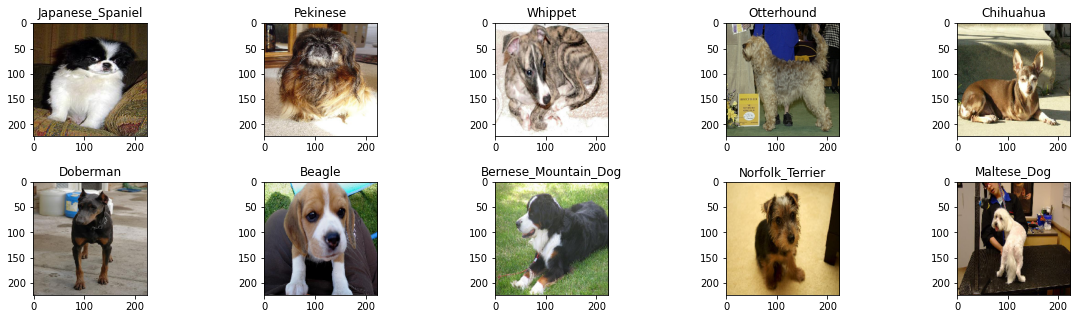

In [7]:
plt.figure(figsize=(20,5))

for i in range(10):
    random_img = np.random.randint(0, len(X))

    plt.subplot(2,5,i+1)
    plt.subplots_adjust(hspace = .4)
    plt.title(get_ylabel(y[random_img]))
    plt.imshow(X[random_img])

## Train- Vali- Test- Split

In [ ]:
train_ratio = 0.6
validation_ratio = 0.2
test_ratio = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 1 - train_ratio)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size= test_ratio/(test_ratio + validation_ratio)) 

In [ ]:
print('Size of X_train: ' + str(len(X_train)) + '; Size of X_val: ' + str(len(X_val)) + '; Size of X_test: ' + str(len(X_test)))

**Save** to directory:

In [ ]:
savez_compressed(split_path + '/X_train.npz', X_train)
savez_compressed(split_path + '/X_test.npz', X_test)
savez_compressed(split_path + '/X_val.npz', X_val)

np.save(file=split_path + '/y_train.npy', arr = y_train)
np.save(file=split_path + '/y_test.npy', arr = y_test)
np.save(file=split_path + '/y_val.npy', arr = y_val)

**Upload** to Google Cloud Storage from local directory:

In [ ]:
upload_to_bucket(split_path + '/X_train.npz', data_bucket)
upload_to_bucket(split_path + '/X_test.npz', data_bucket)
upload_to_bucket(split_path + '/X_val.npz', data_bucket)
upload_to_bucket(split_path + '/y_train.npy', data_bucket)
upload_to_bucket(split_path + '/y_test.npy', data_bucket)
upload_to_bucket(split_path + '/y_val.npy', data_bucket)

**Download** from Google Cloud Storage to local directory: 

In [8]:
download_file_from_bucket(split_path + '/X_train.npz', data_bucket)
download_file_from_bucket(split_path + '/X_test.npz', data_bucket)
download_file_from_bucket(split_path + '/X_val.npz', data_bucket)
download_file_from_bucket(split_path + '/y_train.npy', data_bucket)
download_file_from_bucket(split_path + '/y_test.npy', data_bucket)
download_file_from_bucket(split_path + '/y_val.npy', data_bucket)

Saved
Saved
Saved
Saved
Saved
Saved


**Load** from directory:

In [9]:
X_train = load(split_path + '/X_train.npz')['arr_0']
X_test = load(split_path + '/X_test.npz')['arr_0']
X_val = load(split_path + '/X_val.npz')['arr_0']

y_train = np.load(split_path + '/y_train.npy')
y_test = np.load(split_path + '/y_test.npy')
y_val = np.load(split_path + '/y_val.npy')

Check breed-distribution across the split datasets.

In [26]:
sum_train = np.sum(y_train, axis=0)
sum_test = np.sum(y_test, axis=0)
sum_val = np.sum(y_val, axis=0)

sums_in_split = np.array([sum_train, sum_test, sum_val])
data_length = len(y_train) + len(y_test) + len(y_val)
dist_in_split = sums_in_split / data_length * 100

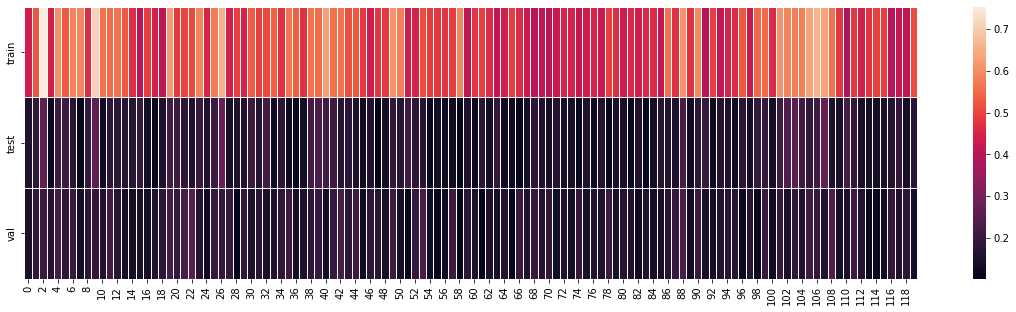

In [72]:
plt.figure(figsize=(20,5))

ax= sns.heatmap(dist_in_split, linewidth=0.5, yticklabels = ['train', 'test', 'val'])
plt.show()

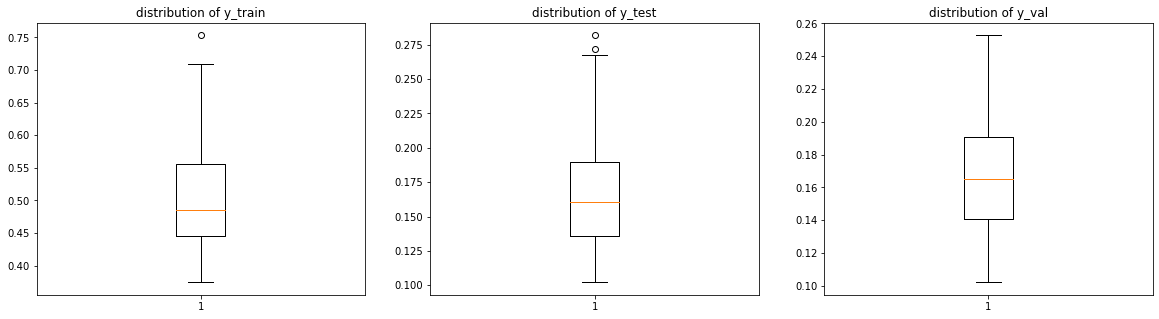

In [97]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.boxplot(dist_in_split[0])
plt.title('distribution of y_train')

plt.subplot(1,3,2)
plt.boxplot(dist_in_split[1])
plt.title('distribution of y_test')

plt.subplot(1,3,3)
plt.boxplot(dist_in_split[2])
plt.title('distribution of y_val')

plt.show()

Distribution of breeds across the three sub-datasets look okay overall with some outliers. Whether this will have an impact on the training results, we' ll see later.